# Last layer vs Full diagnostics for MLPs

In [1]:
from itertools import product

import numpy as np
from joblib import delayed, Parallel
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, kendalltau
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import clone


from mislabeled.probe import ApproximateLOO, linearize, SelfInfluence, Leverage
from mislabeled.probe._fisher import linearize_mlp_fisher
from mislabeled.probe._linear import linearize_mlp
from mislabeled.datasets.toy import blobs, circles, spirals, xor_camembert

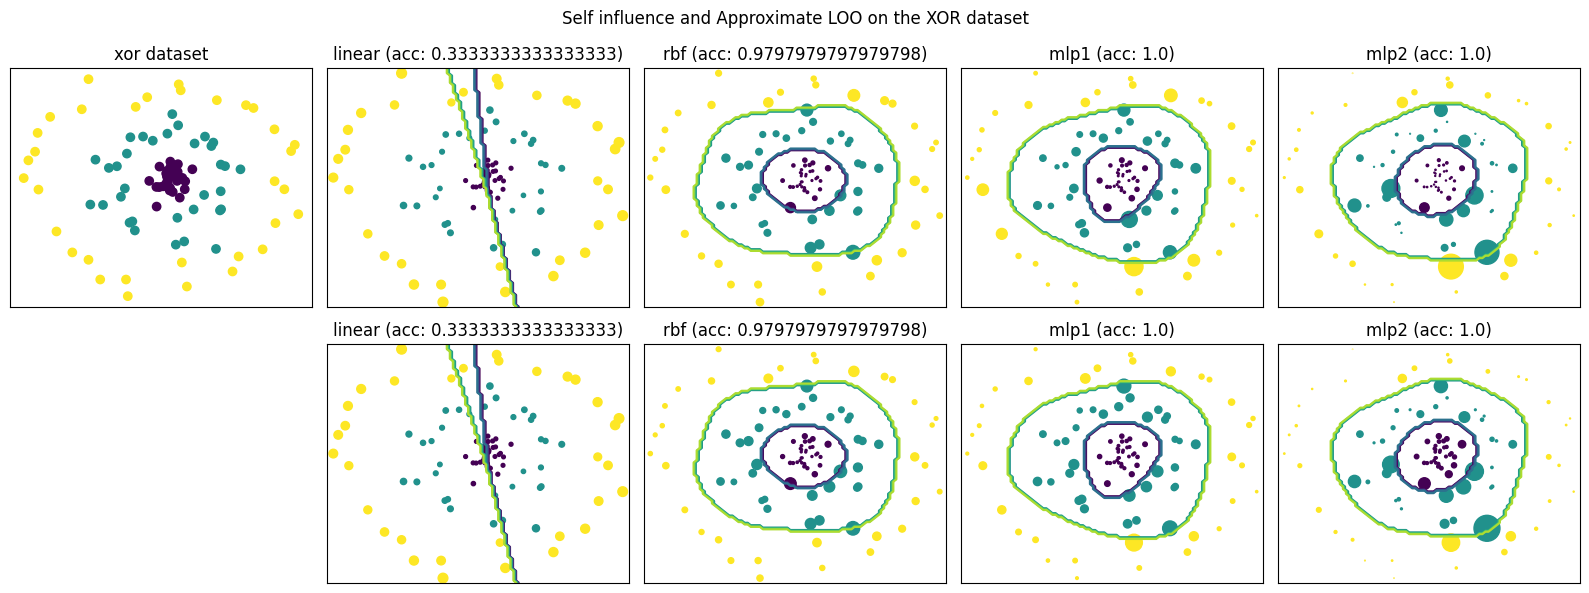

In [2]:
X, y = circles(100, 3, random_state=1, shuffle=True, spread=0.2)
X = StandardScaler().fit_transform(X)
# X1 = StandardScaler().fit_transform(X1)
# X = np.vstack((X1, X1 @ np.array([[0, -1], [1, 0]])))
# y = np.hstack((np.ones(X1.shape[0]), np.zeros(X1.shape[0]))).astype(int)

hyper_params = dict(solver="lbfgs", random_state=1, alpha=1, activation="tanh", tol=1e-6, max_iter=1000)
models = dict(
    linear=MLPClassifier([], **hyper_params ),
    rbf=make_pipeline(RBFSampler(n_components=100, random_state=1), MLPClassifier([], **hyper_params)),
    mlp1=MLPClassifier([100], **hyper_params),
    mlp2=MLPClassifier([100]*2, **hyper_params),
    # mlp3=MLPClassifier([100]*3, **hyper_params),
)
linearizations = {
    "fisher":linearize_mlp_fisher,
    "last-layer":linearize_mlp
}
# probes = {
#     "inf":SelfInfluence(),
#     "new":ApproximateLOO()
# }

scores = {f"{linearization_name}":{} for linearization_name in linearizations.keys()}

fig, axes = plt.subplots(len(linearizations), len(models) + 1,  figsize=(len(models)*4, len(linearizations)*3))


axes[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axes[0, 0].set_xticks(())
axes[0, 0].set_yticks(())
axes[0, 0].set_title("xor dataset")

axes[1, 0].axis("off")

for (j, (linearization_name, linearization)), (i, (name, model)) in product(enumerate(linearizations.items()), enumerate(models.items())):
    model.fit(X, y)
    score = model.score(X, y)
    linearize.register(MLPClassifier, linearization)
    experiment_name = f"{linearization_name}"
    scores[experiment_name][name] = ApproximateLOO()(model, X, y)

    ax = axes[j, i+1]
    ax.scatter(
        X[:, 0], X[:, 1], c=y, s=20 * scores[experiment_name][name] / np.mean(scores[experiment_name][name])
    )
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f"{name} (acc: {score})")

    DecisionBoundaryDisplay.from_estimator(model, X, eps=0.1, ax=ax, plot_method="contour")

fig.suptitle("Self influence and Approximate LOO on the XOR dataset")
plt.tight_layout()
plt.show()

/Users/pierrenodet/Library/Application Support/hatch/env/virtual/mislabeled/kAB_3k5V/mislabeled/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pierrenodet/Library/Application Support/hatch/env/virtual/mislabeled/kAB_3k5V/mislabeled/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pierr

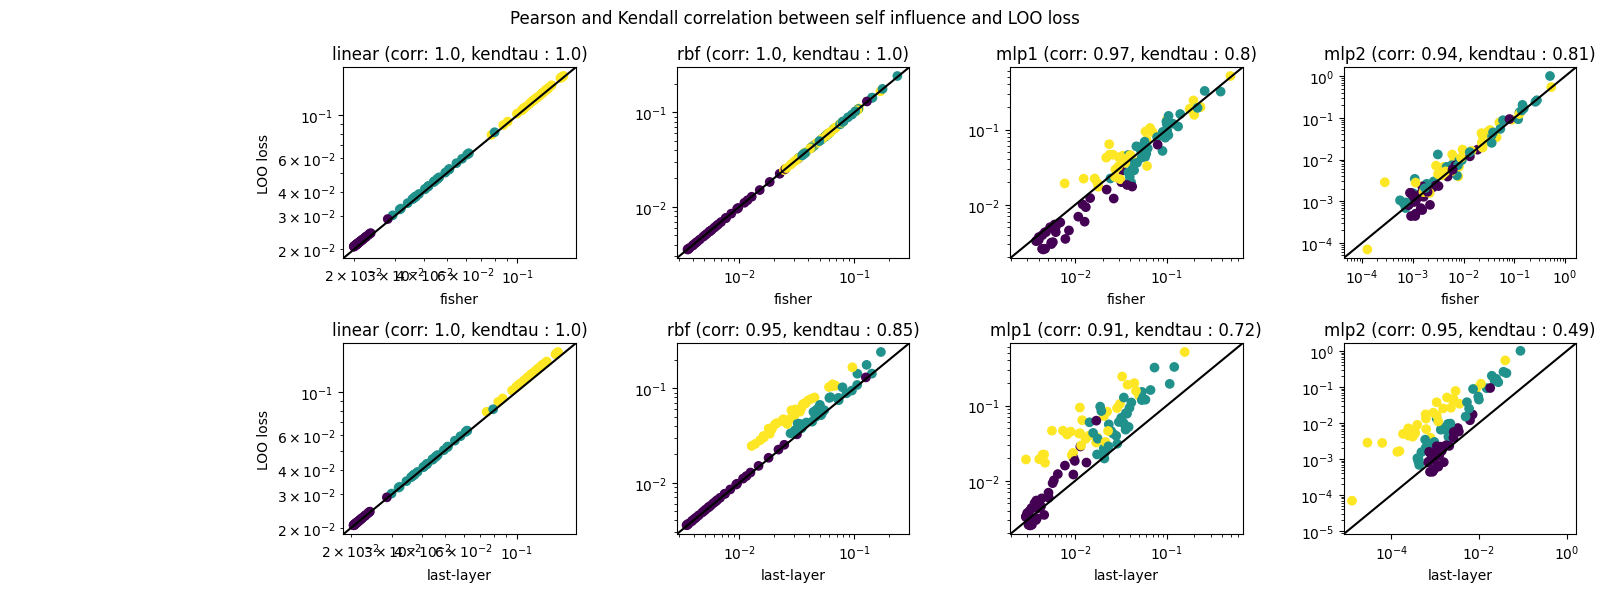

In [3]:
fig, axes = plt.subplots(len(linearizations), len(models) + 1, figsize=(len(models)*4, len(linearizations)*3))

axes[0, 0].axis("off")
axes[1, 0].axis("off")
axes[1, 1].set_ylabel("LOO loss")
axes[0, 1].set_ylabel("LOO loss")

for i, (name, model) in enumerate(models.items()):

    model.fit(X, y)

    def objective(model, X, y):
        linearized, X, y = linearize(model, X, y)
        linearized.regul = None
        return linearized.objective(X, y)

    def eval(model, X, y, train, test):

        loo_model = clone(model).fit(X[train], y[train])
        loo_ll_diff = objective(model, X[test], y[test])- objective(loo_model, X[test], y[test])
        return loo_ll_diff
    
    loo_diff = Parallel(n_jobs=-1)(
        delayed(eval)(model, X, y, train, test) for train, test in LeaveOneOut().split(X)
    )
    loo_diff = np.asarray(loo_diff)

    for j, (linearization_name, linearization) in enumerate(linearizations.items()):

        ax = axes[j, i+1]
        pear = pearsonr(scores[linearization_name][name], loo_diff).statistic
        kendtau = kendalltau(scores[linearization_name][name], loo_diff).statistic
        ax.scatter(-scores[linearization_name][name], -loo_diff, c=y)
        ax.set_xscale("log")
        ax.set_yscale("log")
        min = np.min([ax.get_xlim(), ax.get_ylim()])
        max = np.max([ax.get_xlim(), ax.get_ylim()])
        ax.set_xlim((min, max))
        ax.set_ylim((min, max))
        ax.axline((min, min), (max, max), color="black")
        ax.set_xlabel(linearization_name)
        ax.set_title(f"{name} (corr: {round(pear,2)}, kendtau : {round(kendtau, 2)})")

fig.suptitle("Pearson and Kendall correlation between self influence and LOO loss")
plt.tight_layout()
plt.show()